In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.1+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

## Dataset creation and preprocessing
Useful resources:
- https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html
- https://www.youtube.com/watch?v=Q5T-JdyVCfs
- https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial15/Tutorial15.ipynb

In [3]:
DATASET_PATH = './dataset_LUMINAL_A_B.csv'
PEARSON_TH = 0.9

In [4]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import LabelEncoder, scale
import torch_geometric.transforms as T

df = pd.read_csv(DATASET_PATH)
label_encoder = LabelEncoder()
df['l'] = label_encoder.fit_transform(df.l)

# normalize each feature BEFORE computing pearson coefficient
x_scaled = scale(df.drop(labels=['l'], axis=1).values)

pearson_mat = np.corrcoef(x_scaled)

x = torch.tensor(x_scaled, dtype=torch.float32)
y = torch.tensor(df['l'].values, dtype=torch.long)

# since pearson_mat is symmetric
edges = np.argwhere(pearson_mat > 0.0)

# discard self-loops
not_self_loops = edges[:, 0] != edges[:, 1]
edges = edges[not_self_loops]
edge_idx = torch.tensor(edges.T, dtype=torch.long)

data = Data(x=x, edge_index=edge_idx, y=y)
transform = T.Compose([
    T.RemoveIsolatedNodes(),
    T.RandomNodeSplit(num_train_per_class=40, num_val=0, num_test=20)
])
data = transform(data)

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[100, 1022], edge_index=[2, 4304], y=[100], train_mask=[100], val_mask=[100], test_mask=[100])
Number of nodes: 100
Number of edges: 4304
Average node degree: 43.04
Number of training nodes: 80
Training node label rate: 0.80
Has isolated nodes: False
Has self-loops: False
Is undirected: True


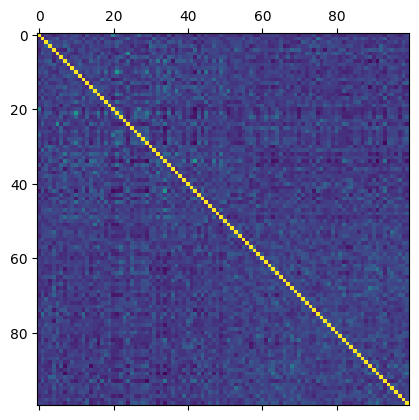

In [5]:
plt.matshow(pearson_mat)

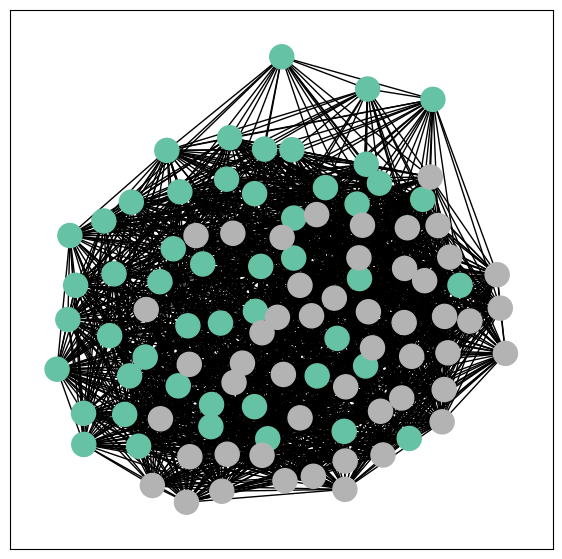

In [6]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [7]:
NUM_FEATURES = 1022
NUM_CLASSES = 2

## MLP

In [8]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(NUM_FEATURES, hidden_channels)
        self.lin2 = Linear(hidden_channels, NUM_CLASSES)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1022, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


In [16]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 1001):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.7443
Epoch: 002, Loss: 0.4925
Epoch: 003, Loss: 0.4756
Epoch: 004, Loss: 0.2959
Epoch: 005, Loss: 0.1833
Epoch: 006, Loss: 0.1085
Epoch: 007, Loss: 0.0645
Epoch: 008, Loss: 0.0900
Epoch: 009, Loss: 0.0535
Epoch: 010, Loss: 0.0789
Epoch: 011, Loss: 0.0320
Epoch: 012, Loss: 0.0576
Epoch: 013, Loss: 0.0170
Epoch: 014, Loss: 0.0570
Epoch: 015, Loss: 0.0188
Epoch: 016, Loss: 0.0359
Epoch: 017, Loss: 0.0506
Epoch: 018, Loss: 0.0791
Epoch: 019, Loss: 0.0097
Epoch: 020, Loss: 0.0449
Epoch: 021, Loss: 0.0310
Epoch: 022, Loss: 0.0331
Epoch: 023, Loss: 0.0327
Epoch: 024, Loss: 0.0200
Epoch: 025, Loss: 0.0180
Epoch: 026, Loss: 0.0134
Epoch: 027, Loss: 0.0264
Epoch: 028, Loss: 0.0570
Epoch: 029, Loss: 0.0071
Epoch: 030, Loss: 0.0142
Epoch: 031, Loss: 0.0030
Epoch: 032, Loss: 0.0268
Epoch: 033, Loss: 0.0181
Epoch: 034, Loss: 0.0247
Epoch: 035, Loss: 0.0213
Epoch: 036, Loss: 0.0301
Epoch: 037, Loss: 0.0169
Epoch: 038, Loss: 0.0441
Epoch: 039, Loss: 0.0089
Epoch: 040, Loss: 0.0162


In [17]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9000


## GNN

In [18]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(NUM_FEATURES, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, NUM_CLASSES)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1022, 16)
  (conv2): GCNConv(16, 2)
)


Embeddings before training

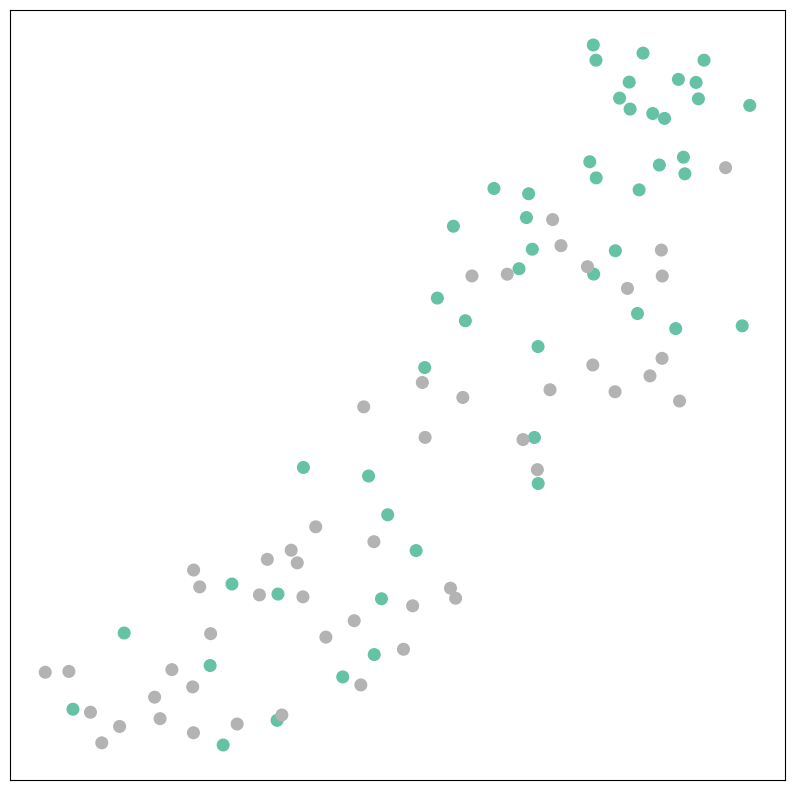

In [19]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [20]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.6796
Epoch: 002, Loss: 0.6005
Epoch: 003, Loss: 0.5779
Epoch: 004, Loss: 0.5228
Epoch: 005, Loss: 0.5078
Epoch: 006, Loss: 0.4824
Epoch: 007, Loss: 0.5164
Epoch: 008, Loss: 0.4727
Epoch: 009, Loss: 0.4865
Epoch: 010, Loss: 0.4832
Epoch: 011, Loss: 0.5551
Epoch: 012, Loss: 0.4755
Epoch: 013, Loss: 0.4795
Epoch: 014, Loss: 0.6219
Epoch: 015, Loss: 0.5026
Epoch: 016, Loss: 0.4637
Epoch: 017, Loss: 0.4822
Epoch: 018, Loss: 0.5987
Epoch: 019, Loss: 0.4823
Epoch: 020, Loss: 0.5030
Epoch: 021, Loss: 0.4777
Epoch: 022, Loss: 0.4641
Epoch: 023, Loss: 0.4796
Epoch: 024, Loss: 0.4654
Epoch: 025, Loss: 0.4281
Epoch: 026, Loss: 0.4507
Epoch: 027, Loss: 0.4612
Epoch: 028, Loss: 0.4622
Epoch: 029, Loss: 0.4418
Epoch: 030, Loss: 0.4420
Epoch: 031, Loss: 0.4283
Epoch: 032, Loss: 0.4383
Epoch: 033, Loss: 0.4288
Epoch: 034, Loss: 0.4504
Epoch: 035, Loss: 0.4362
Epoch: 036, Loss: 0.4375
Epoch: 037, Loss: 0.4293
Epoch: 038, Loss: 0.4093
Epoch: 039, Loss: 0.4198
Epoch: 040, Loss: 0.4549


In [21]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9500


Embeddings after training

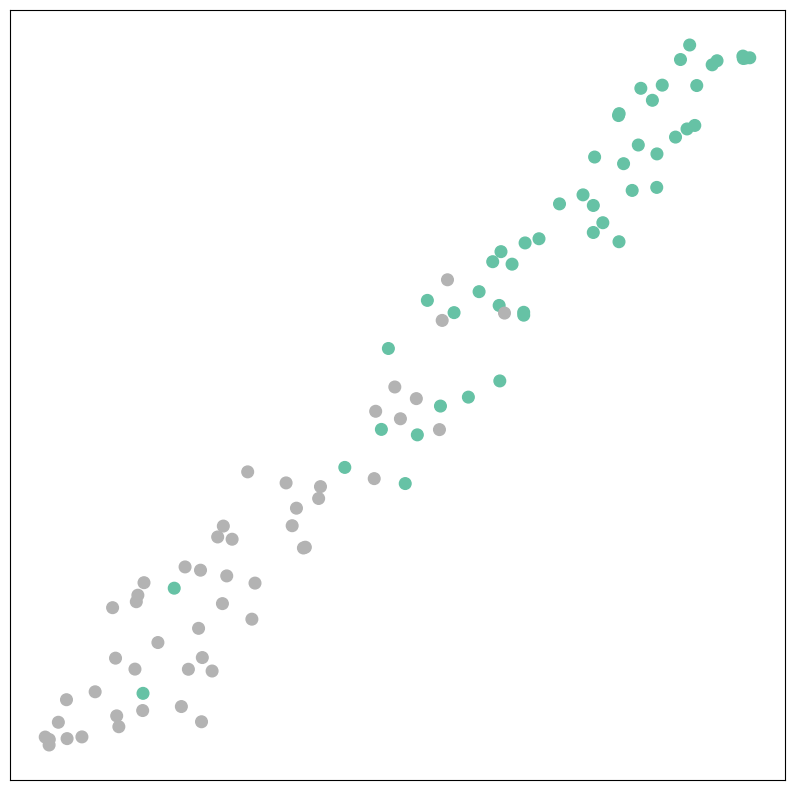

In [15]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)